# Recommendations with IBM

In this notebook, we will be putting recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, we will will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os 

%matplotlib inline

os.chdir(r'C:\Users\ogzpython\Desktop\ml\ibm_rec')
df = pd.read_csv(r'.\data\user-item-interactions.csv')
df_content = pd.read_csv(r'.\data\articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
import project_tests as t
import pickle

In [4]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
df['email'].value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

In [6]:
median_val = df['email'].value_counts().describe()['50%'] 
# 50% of individuals interact with 3 number of articles or fewer.
median_val

3.0

In [7]:
max_views_by_user = df['email'].value_counts().describe()['max'] 
max_views_by_user
# The maximum number of user-article interactions by any 1 user is 364.

364.0

`2.` removing duplicate articles from the **df_content** dataframe.  

In [8]:
df_content.drop_duplicates(subset= ['article_id'],inplace= True)

`3.` below to find:

**a.** The number of unique articles that have an interaction with a user. 

In [9]:
unique_articles = df['article_id'].value_counts().count()
unique_articles

714

##### there are 714 unique articles in the user dataset that have interaction

**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>

In [10]:
total_articles = df_content['article_id'].value_counts().count()
total_articles

1051

##### there are 1051 unique articles in the content dataset

**c.** The number of unique users in the dataset. (excluding null values) <br>

In [11]:
unique_users = df['email'].value_counts().describe()['count']
unique_users

5148.0

##### there are 5148 unique users in the dataset

**d.** The number of user-article interactions in the dataset.

In [12]:
user_article_interactions = df.shape[0]
user_article_interactions

45993

#### there are 45993 user-article inteactions in the dataset.

`4.` most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
df.groupby(['article_id']).agg('count')['title'].sort_values(ascending= False).reset_index()[0:1]

,article_id,title
0,1429.0,937


##### article id : 1429 is the most viewed with 937 reads.

In [14]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded



In [15]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [16]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(['title'])['article_id'].count().nlargest(n).reset_index()['title'])
    return top_articles # Returns the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(['article_id'])['title'].count().nlargest(n).reset_index()['article_id'])
    # Your code here
 
    return top_articles # Return the top article ids

In [17]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.`function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then zero will be placed where the user-row meets for that article-column**. 


In [18]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id'])['article_id'].value_counts().unstack().fillna(0).apply(lambda x : x.apply(lambda x : 1 if x >.0 else .0))
    
    return user_item # return the user_item matrix 

`2.` the function below which takes a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it makes sense to compute similarity as the dot product of two users. 


In [19]:
user_item = create_user_item_matrix(df)
test = np.dot(np.array(user_item[0]),user_item.to_numpy())

In [20]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    sim = np.dot(user_item[user_id-1:user_id],user_item.transpose())
    # sort by similarity
    sim = pd.DataFrame(sim)
    sim = sim.transpose()
    sim.columns = ['sim']
    #sim = sim[sim['sim']>0]
    sim = sim.sort_values(['sim'],ascending = False)
    # create list of just the ids
    sim['id'] = sim.index+1
    most_similar_users = list(sim.id)
    # remove the own user's id
    try :
        most_similar_users.remove((user_id))
    except:
        pass
       
    return most_similar_users # return a list of the users in order from most to least similar
        

`3.` Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles we can recommend. The functions below to return the articles we would recommend to each user.

In [21]:
df.head(5)

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [22]:
df_content.head(5)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    mask = df['article_id'].isin(article_ids)
    article_names = list(set(df[mask]['title']))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    mask = df['user_id']==user_id
    article_ids = list(set(df[mask]['article_id']))
    
    
    #mask_full_name = df_content['article_id'].isin(article_ids)
    #article_names = list(set(df_content[mask_full_name]['doc_full_name']))
    article_names = get_article_names(article_ids)
    
    
    
    return article_ids, article_names # return the ids and names



    return recs # return your recommendations for this user_id    

In [24]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    n = 0
    recs = []
    iteration = 0
    article_ids_chosen, article_names_chosen = get_user_articles(user_id)
    while n<m:
        similars = find_similar_users(user_id)[iteration]
        article_ids, article_names = get_user_articles(similars)
        temp_recs = [elem for elem in article_ids if not elem in article_ids_chosen] 
        temp_recs = [elem for elem in temp_recs if not elem in recs]
        recs.extend(temp_recs[0:10-n])
        iteration = iteration+1
        n = len(recs)
        
    return recs
    

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [25]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    neighbors_df = np.dot(user_item[user_id-1:user_id],user_item.transpose())
    neighbors_df = pd.DataFrame(neighbors_df)
    neighbors_df = neighbors_df.transpose()
    neighbors_df.columns = ['similarity']
    neighbors_df = neighbors_df.sort_values(['similarity'],ascending = False)
    neighbors_df['neighbors_id'] = neighbors_df.index+1
    num_interactions_df = df[['user_id','article_id']].groupby(['user_id'])['article_id'].count().reset_index()
    num_interactions_df.columns = ['user_id','num_interactions']
    neighbors_df = neighbors_df.merge(num_interactions_df,how='left', left_on = ['neighbors_id'], right_on = ['user_id']).drop(['user_id'],1)
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'],ascending = False)
    
    
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    try:
        n = 0
        recs = []
        iteration = 0
        article_ids_chosen, article_names_chosen = get_user_articles(user_id)
        while n<m: 
            get_top_sorted_users(user_id)
            most_similar_users = list(get_top_sorted_users(user_id).neighbors_id)
            # remove the own user's id
            try :
                most_similar_users.remove((user_id))
            except:
                pass
            similars = most_similar_users[iteration]
            article_ids, article_names = get_user_articles(similars)
            temp_recs = [elem for elem in article_ids if not elem in article_ids_chosen] 
            temp_recs = [elem for elem in temp_recs if not elem in recs]
            recs.extend(temp_recs[0:10-n])
            iteration = iteration+1
            n = len(recs)
        rec_names = get_article_names(recs)
        
    except:
        recs = []
        recs = get_top_article_ids(10, df=df)
        rec_names = get_top_articles(10, df=df)
        
        
        
    
    
   
    
    
    
    
    return recs, rec_names

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Is there a  better way we might make recommendations? 

# If we add new user engine would recommend most popular titles. 

In [26]:
new_user_recs = user_user_recs_part2(0, m=10)
new_user_recs

([1429.0,
  1330.0,
  1431.0,
  1427.0,
  1364.0,
  1314.0,
  1293.0,
  1170.0,
  1162.0,
  1304.0],
 ['use deep learning for image classification',
  'insights from new york car accident reports',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm',
  'healthcare python streaming application demo',
  'finding optimal locations of new store using decision optimization',
  'apache spark lab, part 1: basic concepts',
  'analyze energy consumption in buildings',
  'gosales transactions for logistic regression model'])

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [27]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [28]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

In [30]:
u, s, vt = np.linalg.svd(user_item)

In [34]:
u.shape,s.shape,vt.shape

((5149, 5149), (714,), (714, 714))

#### There are no null values in our dataset. We only evaluate read/not read in this engine. If it was a rating there would be null values for unread articles so we would need another method

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

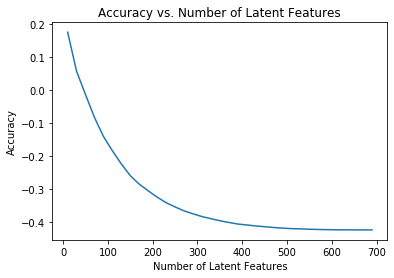

In [36]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 



In [149]:
df_train = df.head(40000)
df_test = df.tail(5993)
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(set(df_test['user_id']))
    test_arts = list(set(df_test['article_id']))
                                        
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

* How many users can we make predictions for in the test set?  

In [86]:
len(set(df_train[df_train['user_id'].isin(set(df_test['user_id']))]['user_id']))

20

* How many users are we not able to make predictions for because of the cold start problem?

In [98]:
user_item_test.shape[0] - len(set(df_train[df_train['user_id'].isin(set(df_test['user_id']))]['user_id']))

662

* How many articles can we make predictions for in the test set?  

In [104]:
len(set(df_train[df_train['article_id'].isin(set(df_test['article_id']))]['article_id']))

574

* How many articles are we not able to make predictions for because of the cold start problem?

In [108]:
len(test_arts) - user_item_test.shape[1]

0

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [150]:
# fit SVD on the user_item_train matrix
user_item_train = user_item_train[user_item_train.index.isin(set(df_train[df_train['user_id'].isin(set(df_test['user_id']))]['user_id']))]
user_item_train = user_item_train[set(df_train[df_train['article_id'].isin(set(df_test['article_id']))]['article_id'])]
user_item_test = user_item_test[user_item_test.index.isin(set(df_train[df_train['user_id'].isin(set(df_test['user_id']))]['user_id']))]
user_item_test = user_item_test[set(df_train[df_train['article_id'].isin(set(df_test['article_id']))]['article_id'])]
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [151]:
k = 20
# restructure with k latent features
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
# take dot product
user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
# compute error for each prediction to actual value
diffs = np.subtract(user_item_test, user_item_est) 
# total errors and keep track of them
err = np.sum(np.sum(np.abs(diffs)))


In [152]:
err

408.0

`6.` cell below to comment on the results founded in the previous part. Given the circumstances of results, discussion of what might we do to determine if the recommendations we make with any of the above recommendation systems are an improvement to how users currently find articles? 

#### I think all the systems we created are improvements to find articles. However, we need a ratings, read completion ratio, etc.. to make better recommendations. 